# CICERO SCM notebook example - interactive input

Import some stuff

In [3]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import xarray as xr
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

/tmp/ipykernel_1979076/3555279312.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Some functions to help with handling my own data

In [4]:
def to_df(cscm):
    """Convert the results of a CICEROSCM object to a DataFrame"""
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

def calc_beta(mol_mass):
    """Calculate the beta value for a given molecular mass"""
    return 1.7758620689655172e8 * mol_mass * 1e-9


def check_hfc(species):
    """Check if the species is an HFC and remove the hyphen"""
    if "HFC-" in species:
        sp_in = species.replace("-", "")
    else:
        sp_in = species
    return sp_in

def zero_mf(species):
    """Create a DataFrame of zeros for a given species"""
    sp_in = check_hfc(species)
    dfc = pd.DataFrame(index=emi_input.index, columns=[sp_in], data=0)
    dfc.index.name = "Component"
    return dfc

test_data_dir = "/user/home/lw13938/work/ciceroscm/tests/test-data/"

Read in CICERO-SCM datafiles

In [5]:
# Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')

/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_gas = pd.read_csv(filename, delim_whitespace=True, index_col=0)


Add AGAGE data and add missing gases. \
Gases are updated with the WMO 2022 lifetimes and SARFs.

In [6]:
# These are all the gases that are considered. Can add more if available or needed.
groups = {"all":[],
          "CFCs": ["CFC-11", "CFC-12", "CFC-113", "CFC-114", "CFC-115"],
          "HCFCs": ["HCFC-22", "HCFC-141b", "HCFC-142b"],
          "HFCs": ["HFC-23", "HFC-32", "HFC-134a", "HFC-143a", "HFC-125",
                   "HFC-4310mee", "HFC-227ea", "HFC-365mfc",
                   "HFC-236fa", "HFC-245fa"], 
          "Solvents": ["CCl4", "CH3CCl3"],
          "PFCs":["CF4", "C2F6", "C3F8", "C4F8", "C4F10","C6F14"],
          "Other":["SF6", "NF3"],
          "Halons": ["H-1301", "H-2402", "H-1211"]}


df_rf = pd.read_csv("/user/home/lw13938/Python/bm_plots/Jens_RF_file/radiative_efficiency.updated.csv", comment="#")
rf_dict = {}
for gi, gas in enumerate(df_rf["Species"].values):
    rf_dict[gas] = df_rf["Recommended Adjusted Effective Radiative Efficiency (W/m2/ppX)"].values[gi]

sp_all = combined_list = [item for sublist in groups.values() for item in sublist]

# Add the extra species
df_si = pd.read_csv("work/py12box/py12box/data/inputs/species_info.csv", index_col=0)
for sp in sp_all:
    sp_in = check_hfc(sp)
    mol_mass = df_si.loc[sp]["Molecular mass (g/mol)"]  
    # lifetime = 1/(np.nanmax([1/df_si.loc[sp]["Lifetime stratosphere (years)"],0]) + \
    #             np.nanmax([1/df_si.loc[sp]["Lifetime other troposphere (years)"],0]) + \
    #             np.nanmax([1/df_si.loc[sp]["Lifetime ocean (years)"],0]))  
    lifetime = df_rf.loc[df_rf["Species"] == sp]["WMO (2022) Total Lifetime (years)"].values
    if sp not in gaspam.index and sp.replace("-","") not in gaspam.index:
        continue
        # gaspam = pd.concat((gaspam, pd.DataFrame(index=[sp_in], data= {"EM_UNIT":"Gg", "CONC_UNIT":"ppt", "BETA":calc_beta(mol_mass), "ALPHA":rf_dict[sp]*1e-3, "TAU1":lifetime, "TAU2":0, "TAU3":0, "NAT_EM":0.0, "SARF_TO_ERF":1.0})))
    else:
        gaspam.loc[sp_in] = {"EM_UNIT":"Gg", "CONC_UNIT":"ppt", "BETA":calc_beta(mol_mass), "ALPHA":rf_dict[sp]*1e-3, "TAU1":lifetime, "TAU2":0, "TAU3":0, "NAT_EM":0.0, "SARF_TO_ERF":1.0}
        
# Add missing emissions and update with AGAGE numbers where available
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
        

/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(


In [7]:
0.06 + 0.875 * np.exp(-0.0144 * 25.7)

0.6643441898385452

Run CICERO-SCM. In each loop, each 'group' of F-gases are zeroed and placed in to a dictionary. 

In [8]:
def run_ciceroscm(gaspam_in, emi_input_in, df_ssp2_conc_in, conc_run=False):
    # NBVAL_IGNORE_OUTPUT
    scen = 'test'
    cscm_dir=CICEROSCM({
                "gaspam_data": gaspam_in,
                "emstart": 1750,  
                "conc_run":conc_run,
                "nystart": 1750,
                "nyend": 2024,
                "concentrations_data": df_ssp2_conc_in,
                "emissions_data": emi_input_in,
                "nat_ch4_data": df_nat_ch4,
                "nat_n2o_data": df_nat_n2o,
                "idtm":24,
            })

    # NBVAL_IGNORE_OUTPUT
    cscm_dir._run({
                "results_as_dict":True
            },
        pamset_udm={"threstemp": 7.0, #scales vertical velocity as a function of mixed layer temperature
                        "rlamdo":16.0,#air-sea heat exchange coefficient (wm^-2K^-1)
                        "akapa":0.634, #vertical heat diffusivity
                        "cpi":0.4, #temperature change ratio: polar to nonpolar region
                        "W":4, #vertical velocity (m/yr)
                        "beto":3.5, #ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
                        "lambda":0.54,
                        "mixed":60.0,  #mixed layer depth
                        "foan":0.61, #fraction of northern hemisphere covered by ocean
                        "foas":0.81, #fraction of northern hemisphere covered by ocean
                        "ebbeta":0.0,#atmospheric interhemispheric heat exchange 
                        "fnso":0.7531, #ocean area ratio, northern to southern hemisphere
                        "lm":40, #number of vertical layers
                        "ldtime":12,
                    },
        pamset_emiconc={"lamb": 0.8,
                        "qbmb":0.03,
                        "qo3":0.4,
                        "qdirso2":-.457,
                        "qindso2":-.514,
                        "qbc":.2,
                        "qh2o_ch4":.171,
                        "qoc":-.103,
                        "ref_yr":2010,
                        "idtm":24})
    df_temp = to_df(cscm_dir)
    temp = np.squeeze(df_temp['dT_glob'].values)
    temp = temp[np.isfinite(temp)]
    frcing = df_temp['forcing']['Total_forcing'].values
    frcing = frcing[np.isfinite(frcing)]
    year = df_temp['concentrations'].Year.values
    year = year[np.isfinite(year)]
    return year, temp, frcing


df_dict = {}
df_rf_dict = {}
    
for group in groups:
    emi_input_in = emi_input.copy()
    df_ssp2_conc_in = df_ssp2_conc.copy()
    for sp in groups[group]:
        sp_in = check_hfc(sp)
        df_sp = zero_mf(sp).reindex(emi_input.index, fill_value=0)
        df_ssp2_conc_in[sp_in].update(df_sp[sp_in])
        df_ssp2_conc_in = df_ssp2_conc_in.fillna(0)
    year, temp, forcing = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=True)
    df_dict[group] = temp
    df_rf_dict[group] = forcing

/tmp/ipykernel_1979076/1835058677.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ssp2_conc_in[sp_in].update(df_sp[sp_in])
/tmp/ipykernel_1979076/1835058677.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

KeyError: 'HFC365mfc'

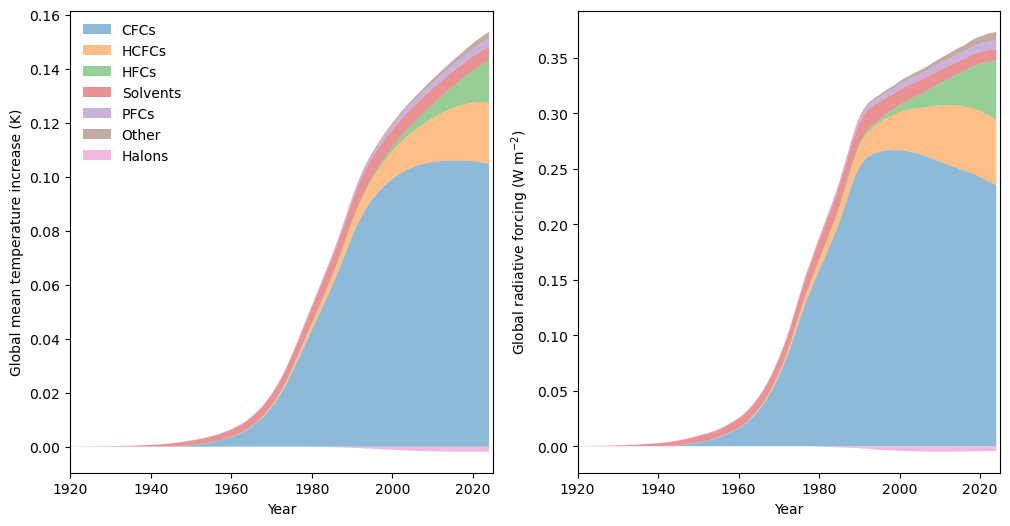

In [7]:
tpr = np.zeros(len(year))
rf = np.zeros(len(year))
temp0 = np.squeeze(df_dict["all"])
rf0 = np.squeeze(df_rf_dict["all"])
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for gr in list(df_dict.keys())[1:len(df_dict.keys())-1]:
    temp = temp0 - df_dict[gr]
    radfor = rf0 - df_rf_dict[gr]
    ax[0].fill_between(year, tpr, tpr+temp, label=gr, alpha=0.5)
    ax[1].fill_between(year, rf, rf+radfor, label=gr, alpha=0.5)
    tpr = tpr+temp
    rf = rf+radfor 
temp = temp0 - df_dict["Halons"]  
rf = rf0 - df_rf_dict["Halons"]   
ax[0].fill_between(year, np.zeros(len(year)), temp, label="Halons", alpha=0.5)
ax[1].fill_between(year, np.zeros(len(year)), rf, label="Halons", alpha=0.5)
ax[0].legend(loc="upper left", frameon=False)
ax[0].set_ylabel("Global mean temperature increase (K)")
ax[1].set_ylabel("Global radiative forcing (W m$^{-2}$)")
for axi in ax:
    axi.set_xlabel("Year")
    axi.set_xlim(1920,2025)